In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import prework as pwk
import string
from time import time


from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import statsmodels as sm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from gensim.models.doc2vec import LabeledSentence, Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

In [3]:
import sys
stdout = sys.stdout

reload(sys)
sys.setdefaultencoding('utf-8')

sys.stdout = stdout

In [4]:
import spacy
spc_nlp = spacy.load('en')

**Add sytactic features from pickle file (syntactic feature generation takes a long time, so pickling is here to save some time)**

In [9]:
df_0 = pd.read_pickle('data/pickles/20180117_part_one.pkl')

In [10]:
'|||'.join(df_0.columns)

'doc_id|||path|||author_code|||essay_content|||label|||unique_lemma|||avg_stc_length|||total_stc|||DT_pos|||POS_adjv_body|||POS_adjv_repeat_rate|||POS_adjv_repeat_cnt|||DT_archs|||DT_max_dp_cnts|||DT_ROOT_idx|||DT_pass_cnt|||DT_mark_cnt|||DT_pos_join|||DT_archs_join|||DT_insent_pos_ngram|||DT_insent_arch_ngram|||DT_max_dp_cnts_std|||DT_ROOT_idx_mean|||DT_pass_cnt_sum|||DT_mark_cnt_sum'

In [12]:
df_2 = df_0[(df_0['label']=='JPN')|(df_0['label']=='KOR')]

In [22]:
countries = df_2.label.unique()

# EDA

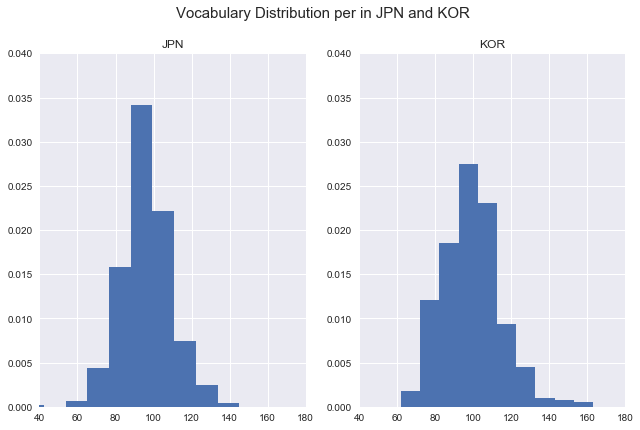

In [67]:
fig, axs = plt.subplots(1, 2)

for a, c in zip(axs.flatten(), countries):
    a.hist(df_2[df_2['label']==c]['unique_lemma'], bins=10, normed=1)
    a.set_xlim(40, 180)
    a.set_ylim(0, 0.04)
    a.set_title(c)
fig.suptitle('Vocabulary Distribution per in JPN and KOR', fontsize=15)
fig.set_size_inches(10.5, 6.5, forward=True)
fig.show()

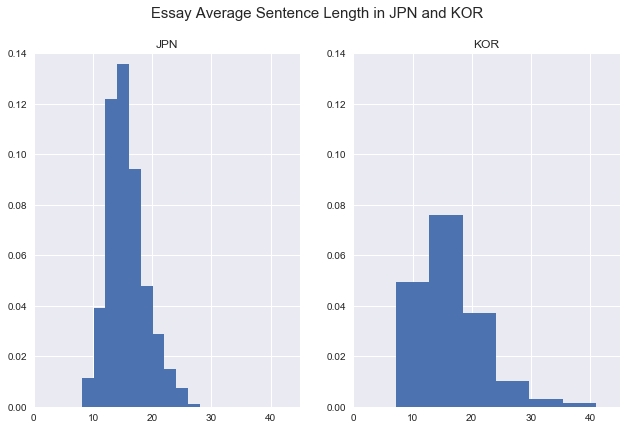

In [66]:
fig, axs = plt.subplots(1, 2)

for a, c in zip(axs.flatten(), countries):
    a.hist(df_2[df_2['label']==c]['avg_stc_length'], bins=10, normed=1)
    a.set_xlim(0, 45)
    a.set_ylim(0, 0.14)
    a.set_title(c)
fig.suptitle('Essay Average Sentence Length in JPN and KOR', fontsize=15)
fig.set_size_inches(10.5, 6.5, forward=True)
fig.show()

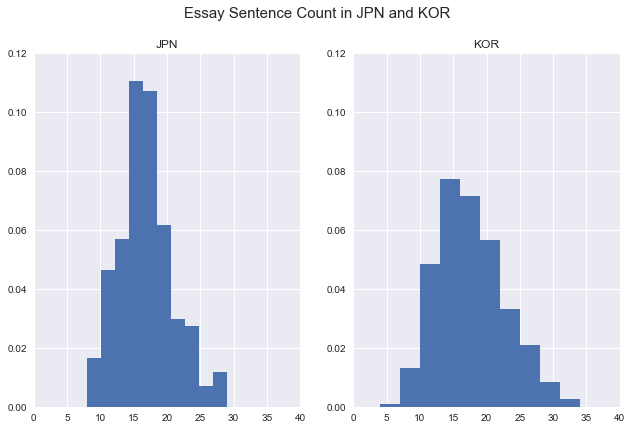

In [65]:
fig, axs = plt.subplots(1, 2)

for a, c in zip(axs.flatten(), countries):
    a.hist(df_2[df_2['label']==c]['total_stc'], bins=10, normed=1)
    a.set_xlim(0, 40)
    a.set_ylim(0, 0.12)
    a.set_title(c)
fig.suptitle('Essay Sentence Count in JPN and KOR', fontsize=15)
fig.set_size_inches(10.5, 6.5, forward=True)
fig.show()

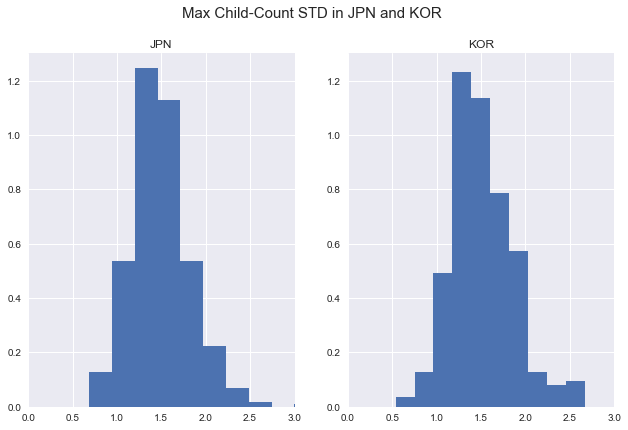

In [72]:
fig, axs = plt.subplots(1, 2)

for a, c in zip(axs.flatten(), countries):
    a.hist(df_2[df_2['label']==c]['DT_max_dp_cnts_std'], bins=10, normed=1)
    a.set_xlim(0, 3)
    a.set_ylim(0, 1.3)
    a.set_title(c)
fig.suptitle('Max Child-Count STD in JPN and KOR', fontsize=15)
fig.set_size_inches(10.5, 6.5, forward=True)
fig.show()

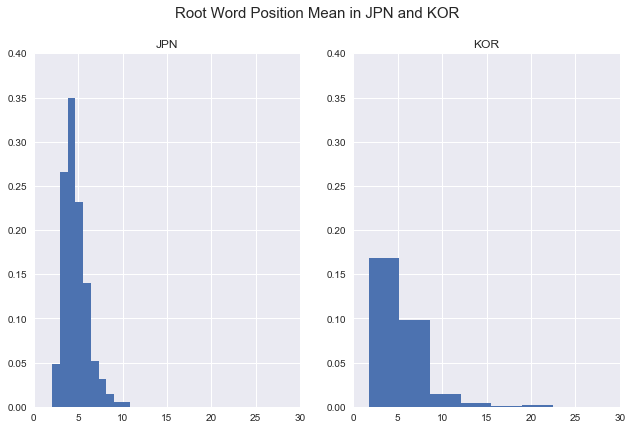

In [73]:
fig, axs = plt.subplots(1, 2)

for a, c in zip(axs.flatten(), countries):
    a.hist(df_2[df_2['label']==c]['DT_ROOT_idx_mean'], bins=10, normed=1)
    a.set_xlim(0, 30)
    a.set_ylim(0, 0.4)
    a.set_title(c)
fig.suptitle('Root Word Position Mean in JPN and KOR', fontsize=15)
fig.set_size_inches(10.5, 6.5, forward=True)
fig.show()

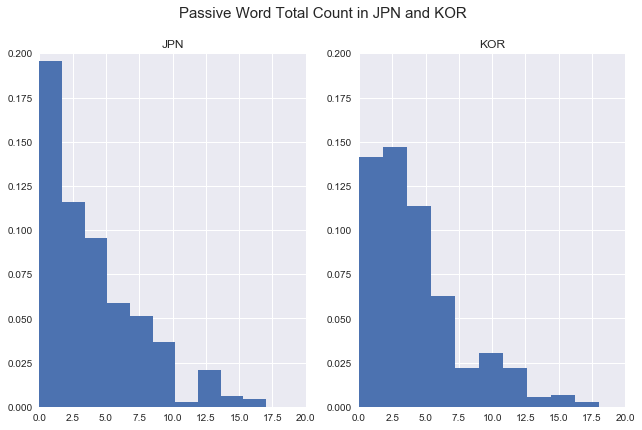

In [74]:
fig, axs = plt.subplots(1, 2)

for a, c in zip(axs.flatten(), countries):
    a.hist(df_2[df_2['label']==c]['DT_pass_cnt_sum'], bins=10, normed=1)
    a.set_xlim(0, 20)
    a.set_ylim(0, 0.2)
    a.set_title(c)
fig.suptitle('Passive Word Total Count in JPN and KOR', fontsize=15)
fig.set_size_inches(10.5, 6.5, forward=True)
fig.show()

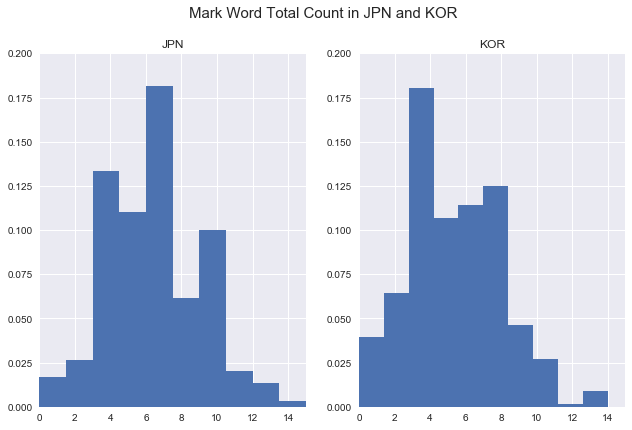

In [80]:
fig, axs = plt.subplots(1, 2)

for a, c in zip(axs.flatten(), countries):
    a.hist(df_2[df_2['label']==c]['DT_mark_cnt_sum'], bins=10, normed=1)
    a.set_xlim(0, 15)
    a.set_ylim(0, 0.2)
    a.set_title(c)
fig.suptitle('Mark Word Total Count in JPN and KOR', fontsize=15)
fig.set_size_inches(10.5, 6.5, forward=True)
fig.show()

### Using only simple numeric essay statistics

In [112]:
X = df_1[['unique_lemma','avg_stc_length','total_stc']]
y = df_1['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [113]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.266864963575


In [114]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)

In [115]:
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,26,4,7,17,7,11,5,11,0,88,0.295455
ENS,7,81,2,2,0,3,2,16,0,113,0.716814
IDN,9,15,3,41,7,11,6,6,12,110,0.027273
JPN,8,1,4,49,6,24,3,0,1,96,0.510417
KOR,12,11,2,32,9,21,5,8,3,103,0.087379
PAK,19,5,4,35,3,24,3,3,1,97,0.247423
PHL,24,22,2,12,0,4,10,10,4,88,0.113636
SIN,13,40,3,2,1,4,12,27,1,103,0.262136
THA,11,18,9,32,3,14,2,3,10,102,0.098039


In [70]:
# Skipping gridsearch for now since this is just basic model exploration
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

0.249726112799


**-**

In [13]:
df_2 = df_1
df_2['DT_max_dp_cnts_std'] = df_2['DT_max_dp_cnts'].apply(lambda x: np.std(x))
df_2['DT_ROOT_idx_mean'] = df_2['DT_ROOT_idx'].apply(lambda x: np.mean(x))
df_2['DT_pass_cnt_sum'] = df_2['DT_pass_cnt'].apply(lambda x: np.sum(x))
df_2['DT_mark_cnt_sum'] = df_2['DT_mark_cnt'].apply(lambda x: np.sum(x))

In [12]:
cols = ['DT_max_dp_cnts_std','DT_ROOT_idx_mean','DT_mark_cnt_sum']
X = df_2[cols]
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.202276834594


In [14]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)

In [15]:
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,JPN,KOR,PAK,PHL,SIN,THA,IDN,All,Accuracy
Actual,,,,,,,,,,,
CHN,38,23,7,10,14,3,6,5,0,106,0.358491
ENS,19,45,11,5,4,3,6,9,0,102,0.441176
IDN,20,22,21,6,24,4,9,1,0,107,0.000000
JPN,17,26,16,7,33,3,1,2,0,105,0.152381
KOR,19,16,10,5,38,2,5,4,0,99,0.050505
PAK,3,13,8,5,63,3,0,1,0,96,0.656250
PHL,22,25,6,8,15,3,8,1,0,88,0.034091
SIN,21,30,2,3,7,7,15,6,0,91,0.164835
THA,14,18,24,3,38,3,3,3,0,106,0.028302


**-**

## POS tagging and syntactic tree parsing features

In [47]:
df_2.columns

Index([u'doc_id', u'path', u'author_code', u'essay_content', u'label',
       u'DT_max_dp_cnts', u'DT_archs', u'DT_ROOT_idx', u'DT_pass_cnt',
       u'DT_mark_cnt', u'POS_adjv_body', u'DT_pos', u'DT_pos_join',
       u'DT_archs_join', u'unique_lemma', u'avg_stc_length', u'total_stc',
       u'POS_adjv_repeat', u'POS_adjv_repeat_sum', u'doc2vec_lm_token',
       u'DT_max_dp_cnts_std', u'DT_ROOT_idx_mean', u'DT_pass_cnt_sum',
       u'DT_mark_cnt_sum'],
      dtype='object')

### Generate tf/tf-idf matrix on pos tag body for essays

In [48]:
#df_2.DT_pos_join

In [306]:
X = df_2['DT_pos_join']
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [307]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.55305832145


In [308]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,53,4,8,13,7,4,2,11,6,108,0.490741
ENS,3,66,1,2,2,4,5,18,4,105,0.628571
IDN,4,3,37,7,4,15,5,4,12,91,0.406593
JPN,5,3,3,68,9,5,1,3,8,105,0.647619
KOR,7,2,10,21,32,4,1,9,11,97,0.329897
PAK,1,3,6,0,0,75,5,0,7,97,0.773196
PHL,9,13,11,6,0,9,42,14,4,108,0.388889
SIN,2,7,1,4,1,2,5,67,2,91,0.736264
THA,5,5,3,7,9,13,5,4,47,98,0.479592


### pos ngram with sentence boundary

In [18]:
n = 4
df_2['DT_insent_pos_ngram'] = df_2['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [56]:
X = df_2['DT_insent_pos_ngram']
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [57]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=5000)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.646561952902


**arch ngram with sentence boundary**

In [17]:
n = 3
df_2['DT_insent_arch_ngram'] = df_2['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [13]:
X = df_2['DT_insent_arch_ngram']
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [14]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=5000)),
    ('clf', LogisticRegression())#solver='newton-cg', multi_class='multinomial'))
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.68889757809


In [15]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,79,2,3,10,4,1,4,3,0,106,0.745283
ENS,2,71,0,0,0,1,5,21,2,102,0.696078
IDN,5,6,61,3,3,8,11,2,8,107,0.570093
JPN,2,1,1,85,10,2,1,0,3,105,0.809524
KOR,11,5,9,12,42,4,5,5,6,99,0.424242
PAK,3,1,3,0,1,83,1,0,4,96,0.864583
PHL,4,3,7,0,3,6,47,17,1,88,0.534091
SIN,3,6,1,0,1,0,6,74,0,91,0.813187
THA,2,4,16,8,4,3,3,2,64,106,0.603774


**-**

In [20]:
df_jpn_kor = df_2[(df_2['label']=='JPN')|(df_2['label']=='KOR')]

In [21]:
X = df_jpn_kor['DT_insent_pos_ngram']
y = df_jpn_kor['label'].values=='JPN'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [22]:
vectorizer = TfidfVectorizer(lowercase=True, max_features=30)
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [23]:
terms = np.array(vectorizer.get_feature_names())

In [24]:
X_test_dtm.shape

(160, 30)

In [25]:
clf = LogisticRegression()
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
pwk.print_confusion_matrix(y_test, y_pred)

Predicted,False,True,All,Accuracy
Actual,,,,
False,41,39,80,0.5125
True,25,55,80,0.6875
All,66,94,160,0.6000


**The top 10 most representive word orders of PAK**

In [217]:
terms[np.argsort(clf.coef_[0])[::-1][:10]]

array([u'adp_adj_noun_punct', u'noun_verb_det_noun', u'noun_verb_adv_adj',
       u'noun_adp_adj_noun', u'noun_adp_noun_punct', u'det_noun_adp_noun',
       u'verb_adj_noun_punct', u'verb_adj_noun_adp', u'adp_det_noun_punct',
       u'det_adj_noun_punct'], 
      dtype='<U19')

**The top 10 most representive word orders of ENS**

In [156]:
terms[np.argsort(clf.coef_[0])[:10]]

array([u'adj_punct_noun_noun', u'pron_verb_adv_verb', u'adp_det_adj_noun',
       u'det_adj_noun_adp', u'verb_adp_det_noun', u'noun_verb_adv_verb',
       u'verb_det_adj_noun', u'adv_verb_det_noun', u'adj_noun_adp_det',
       u'part_verb_det_noun'], 
      dtype='<U19')

In [209]:
pd.set_option('display.max_colwidth', -1)
#df_ens_pak[df_ens_pak['label']=='PAK'][['essay_content','DT_pos']]

In [198]:
#df_ens_pak['xxx'] = df_ens_pak[['essay_content','DT_pos']].apply(lambda x: [s+p for s,p in zip(spc_nlp(x[0].decode('utf-8')).sents, x[1])])
df_ens_pak['essay_pos'] = df_ens_pak[['essay_content','DT_pos']].apply(lambda x: [s.text+p for s,p in zip(spc_nlp(x['essay_content'].decode('utf-8')).sents, x['DT_pos'])], axis=1)


In [26]:
#df_ens_pak[df_ens_pak['label']=='PAK']['essay_pos'].values

**-**

## Concat features

In [27]:
df_jpn_kor.columns

Index([u'doc_id', u'path', u'author_code', u'essay_content', u'label',
       u'DT_max_dp_cnts', u'DT_archs', u'DT_ROOT_idx', u'DT_pass_cnt',
       u'DT_mark_cnt', u'POS_adjv_body', u'DT_pos', u'DT_pos_join',
       u'DT_archs_join', u'unique_lemma', u'avg_stc_length', u'total_stc',
       u'POS_adjv_repeat', u'POS_adjv_repeat_sum', u'doc2vec_lm_token',
       u'DT_max_dp_cnts_std', u'DT_ROOT_idx_mean', u'DT_pass_cnt_sum',
       u'DT_mark_cnt_sum', u'DT_insent_arch_ngram', u'DT_insent_pos_ngram'],
      dtype='object')

In [29]:
X = df_jpn_kor[['DT_insent_pos_ngram','unique_lemma','avg_stc_length']]
y = df_jpn_kor['label'].values=='JPN'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# vectorizer = TfidfVectorizer(lowercase=True, max_features=100)
# X_train_dtm = vectorizer.fit_transform(X_train)
# X_test_dtm = vectorizer.transform(X_test)

In [63]:
import scipy as sp
vectorizer = TfidfVectorizer(lowercase=True, max_features=100).fit(X_train)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32) 

df_all_train = sp.sparse.hstack((vectorizer.transform(X_train['DT_insent_pos_ngram']),X_train[['unique_lemma','avg_stc_length']].values),format='csr')
df_all_test = sp.sparse.hstack((vectorizer.transform(X_test['DT_insent_pos_ngram']),X_test[['unique_lemma','avg_stc_length']].values),format='csr')

df_all_columns=vectorizer.get_feature_names()+X[['unique_lemma','avg_stc_length']].columns.tolist()


In [40]:
X_train[['unique_lemma','avg_stc_length']].values[0]
#df_all_train.todense()[0]

array([ 94.,  10.])

In [57]:
a = sp.sparse.hstack((vectorizer.fit_transform(X_train['DT_insent_pos_ngram'])[0],X_train[['unique_lemma','avg_stc_length']][:1].values),format='csr')

In [61]:
dfx = pd.DataFrame(a.todense(), columns=df_all_columns)

In [62]:
dfx

,adj_adp_noun_noun,adj_noun_adp_noun,adj_noun_part_verb,adj_noun_verb_verb,adj_punct_noun_noun,adp_adj_det_noun,adp_adj_noun_punct,adp_det_adj_noun,adp_det_noun_adp,adp_det_noun_noun,...,verb_det_noun_punct,verb_noun_adp_noun,verb_noun_punct_noun,verb_part_verb_det,verb_verb_adj_noun,verb_verb_adp_det,verb_verb_adp_noun,verb_verb_det_noun,unique_lemma,avg_stc_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105159,0.0,...,0.0,0.125682,0.163969,0.0,0.0,0.270675,0.134452,0.0,94.0,10.0


**-**

## Doc2Vec matrix featurs

#### Vectorize: essay_content, DT_insent_arch_ngram, DT_insent_pos_ngram, DT_arch_join, DT_pos_join

In [133]:
n = 5
df_2['DT_insent_arch_ngram'] = df_2['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [80]:
n = 5
df_2['DT_insent_pos_ngram'] = df_2['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [134]:
cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
(df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
df_input = df_2[cond]

In [135]:
cv_data, test_data = train_test_split(df_input, test_size=0.1)

**Cross validation using different classifiers**

In [164]:
import itertools

ngram_range = [i for i in range(2,11)]
window_range = [i for i in range(1,6)]

combs = list(itertools.product(ngram_range, window_range))

In [155]:
col = 'essay_content'
# essay_content, DT_insent_arch_ngram, DT_insent_pos_ngram, DT_arch_join, DT_pos_join

**Use all possible combinations of ngram and window size to see performance differences**

In [ ]:
col = 'essay_content'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

In [ ]:
col = 'DT_arch_join'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

In [ ]:
col = 'DT_pos_join'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

In [ ]:
col = 'DT_insent_pos_ngram'
for ng in range(2, 21):
    print ('ngram_n: ', ng)
    #print ('window size: ', c[1])
    print ('window size: ', str(1))
    n = ng
    df_2['DT_insent_pos_ngram'] = df_2['DT_pos'].apply(lambda x: pwk.loop_body(x, n))
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, 1, 100, clf, literal=False))

In [ ]:
col = 'DT_insent_arch_ngram'
for ng in range(2, 21):
    print ('ngram_n: ', ng)
    #print ('window size: ', c[1])
    print ('window size: ', str(1))
    n = ng
    df_2['DT_insent_arch_ngram'] = df_2['DT_archs'].apply(lambda x: pwk.loop_body(x, n))
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, 1, 100, clf, literal=False))

**Pick the best hyper patameter and model for final train and test**

In [95]:
train_data, test_data = train_test_split(df_2, test_size=0.7)

col = 'essay_content'
train_docs = pwk.tag_docs(train_data, col, literal=True)
test_docs = pwk.tag_docs(test_data, col, literal=True)
model = pwk.train_doc2vec_model(train_docs, 2, 100)
    
y_train, X_train = pwk.vec_for_learning(model, train_docs)
y_test, X_test = pwk.vec_for_learning(model, test_docs)
    
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [158]:
print accuracy_score(y_test, y_pred)

0.788


In [104]:
pwk.print_confusion_matrix(y_test, y_pred)#['All']['All']

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,225,7,4,10,15,7,3,0,7,278,0.809353
ENS,0,222,3,2,10,3,9,27,7,283,0.784452
IDN,3,13,200,9,10,9,17,7,12,280,0.714286
JPN,15,7,6,221,17,6,1,1,3,277,0.797834
KOR,17,5,5,22,179,8,12,5,25,278,0.643885
PAK,9,3,1,0,1,242,2,1,1,260,0.930769
PHL,4,26,11,2,12,12,201,16,8,292,0.688356
SIN,6,22,1,2,6,2,22,224,0,285,0.785965
THA,9,10,17,14,20,3,16,7,191,287,0.665505


## Feature Selection

**Combining all features**

## Gridsearch on Doc2Vec feature (done on AWS EC2)

In [116]:
# train_data, test_data = train_test_split(df_2, test_size=0.7)

# col = 'essay_content'
# train_docs = pwk.tag_docs(train_data, col, literal=True)
# test_docs = pwk.tag_docs(test_data, col, literal=True)
# model = pwk.train_doc2vec_model(train_docs, 2, 100)

# y_train, X_train = pwk.vec_for_learning(model, train_docs)
# y_test, X_test = pwk.vec_for_learning(model, test_docs)

### Logistic Regression


In [117]:
# model = ('lrclf', LogisticRegression())

# steps = [
#     model
# ]

# grid = {'lrclf__C':[0.001,0.01,0.1,1,10],
#         'lrclf__penalty':['l1','l2']
# }

# pipeline = Pipeline(steps)
# gridsearch = GridSearchCV(pipeline,
#                           grid,
#                           scoring='accuracy',
#                           cv=5,
#                           verbose=1,
#                           n_jobs=-1)

# gridsearch.fit(X_train, y_train)
# best_model = gridsearch.best_estimator_
# print (best_model)

In [118]:
# clf = LogisticRegression(penalty='l2', C=1)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [119]:
# pwk.print_confusion_matrix(y_test, y_pred)

### Random Forest

In [121]:
# model = ('rfclf', RandomForestClassifier())

# steps = [
#     model
# ]
# random_forest_grid = {'rfclf__max_depth': [None, 2, 3, 4],
#                       'rfclf__max_features': ['sqrt', 'log2', None],
#                       'rfclf__min_samples_split': [2, 3, 4],
#                       'rfclf__min_samples_leaf': [1, 2, 3,4],
#                       'rfclf__criterion': ['gini', 'entropy'],
#                       'rfclf__bootstrap': [True, False],
#                       'rfclf__n_estimators': [10000]}

# pipeline = Pipeline(steps)
# gridsearch = GridSearchCV(pipeline,
#                          random_forest_grid,
#                          n_jobs=-1,
#                          cv=5,
#                          verbose=1,
#                          scoring='accuracy')

# gridsearch.fit(X_train, y_train)
# best_rf_model = gridsearch.best_estimator_
# print (best_rf_model)

In [122]:
# clf = RandomForestClassifier(XXX)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [123]:
# pwk.print_confusion_matrix(y_test, y_pred)

### Gradient Boosting

In [124]:
# gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02],
#                           'loss': ['deviance', 'exponential'],
#                           'max_depth': [2, 4],
#                           'min_samples_leaf': [1, 2, 5],
#                           'max_features': [1.0, 0.5],
#                           'n_estimators': [500, 1000, 3000],
#                           'random_state': [1]}

# gbclf_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
#                               gradient_boosting_grid,
#                               cv=5,
#                               verbose=5,
#                               n_jobs=-1,
#                               scoring='accuracy')
# gbclf_gridsearch.fit(X_train, y_train)
# print ("best parameters:", gbclf_gridsearch.best_params_)

# best_gbclf_model = gbclf_gridsearch.best_estimator_
# print best_gbclf_model

In [ ]:
# clf = GradientBoostingClassifier(n_estimators=XXX)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [125]:
# pwk.print_confusion_matrix(y_test, y_pred)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english').fit(X_train)

get_feture_name()....

X_train_dtm = pd.DataFrame(vectorizer.transform(X_train), columns = vectorizer.get...)
X_test_dtm = vectorizer.transform(X_test)